In [1]:
import pydicom
import cv2
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        return self.model(data)

In [3]:
def preprocess_and_predict(image_path, model, device):
    # Load and preprocess image
    dcm = pydicom.read_file(image_path).pixel_array / 255
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float32)
    dcm_array = (dcm_array - 0.494) / 0.252
    img_tensor = torch.tensor(dcm_array).unsqueeze(0).unsqueeze(0)

    # Move to device and run through model
    img_tensor = img_tensor.to(device).float()
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0].cpu()

    return pred, dcm_array

C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted bounding box coordinates: tensor([ 86.5819,  46.2578, 163.9784, 140.2635])


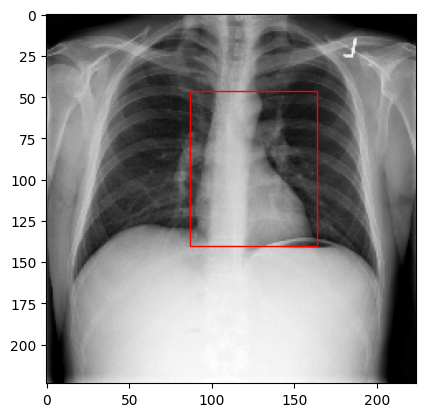

In [4]:
def visualize_prediction(prediction, original_image):
    fig, axis = plt.subplots(1, 1)
    axis.imshow(original_image, cmap='gray')
    heart = patches.Rectangle((prediction[0], prediction[1]), prediction[2] - prediction[0], prediction[3] - prediction[1], edgecolor='r', facecolor='none')
    axis.add_patch(heart)
    plt.show()

# Example usage
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CardiacDetectionModel.load_from_checkpoint('Trained-Model.ckpt', strict=False)
model.to(device)

# Replace with your image path, remember to put .dcm after your address
# Images must be in Dicom format
external_image_path = '$PUT YOUR DICOM IMAGE ADDRESS HERE IN .dcm FORMAT$'  

prediction, original_image = preprocess_and_predict(external_image_path, model, device)
print(f"Predicted bounding box coordinates: {prediction}")

visualize_prediction(prediction, original_image)